In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tools
import itertools

from sklearn import manifold
from sklearn import preprocessing
from sklearn import mixture

In [9]:
from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = '../training_data.csv'
df = pd.read_csv(filename)
df

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [10]:
df['Well Name'].unique()

array(['SHRIMPLIN', 'SHANKLE', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN',
       'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE'], dtype=object)

In [11]:
df['Facies'].unique()

array([3, 2, 8, 6, 7, 4, 5, 9, 1])

In [12]:
facies = df.set_index(['Facies'], drop=False)
data = facies
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Facies,,,,,,,,,,,
3,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
3,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
3,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
3,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
5,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
5,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
5,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669


In [13]:
def plot_bic_aic(features):
    X = features.drop(['NM_M','RELPOS','Depth','Well Name','Formation'], axis=1).sub(features.mean(axis=1), axis=0).values
    X = preprocessing.RobustScaler().fit_transform(X)
    X = manifold.LocallyLinearEmbedding(n_components=5).fit_transform(X)
    y = df['Facies'].values
#     X = normalize(X)
    wells = df["Well Name"].values
    lowest_bic = np.infty
    bic = []
    aic = []
    n_components_range = range(5, 200)
    cv_types = ['tied']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            aic.append(gmm.aic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    bic = np.array(bic)
    aic = np.array(aic)
    color_iter = itertools.cycle(['darkorange','navy'])
    clf = best_gmm
    bars = []
    # Plot the BIC scores
    plt.figure(figsize=(20,10))
    spl = plt.subplot(1, 2, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))

    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model')

    spl = plt.subplot(1, 2, 2)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, aic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))

    plt.xticks(n_components_range)
    plt.ylim([aic.min() * 1.01 - .01 * aic.max(), aic.max()])
    plt.title('AIC score per model')




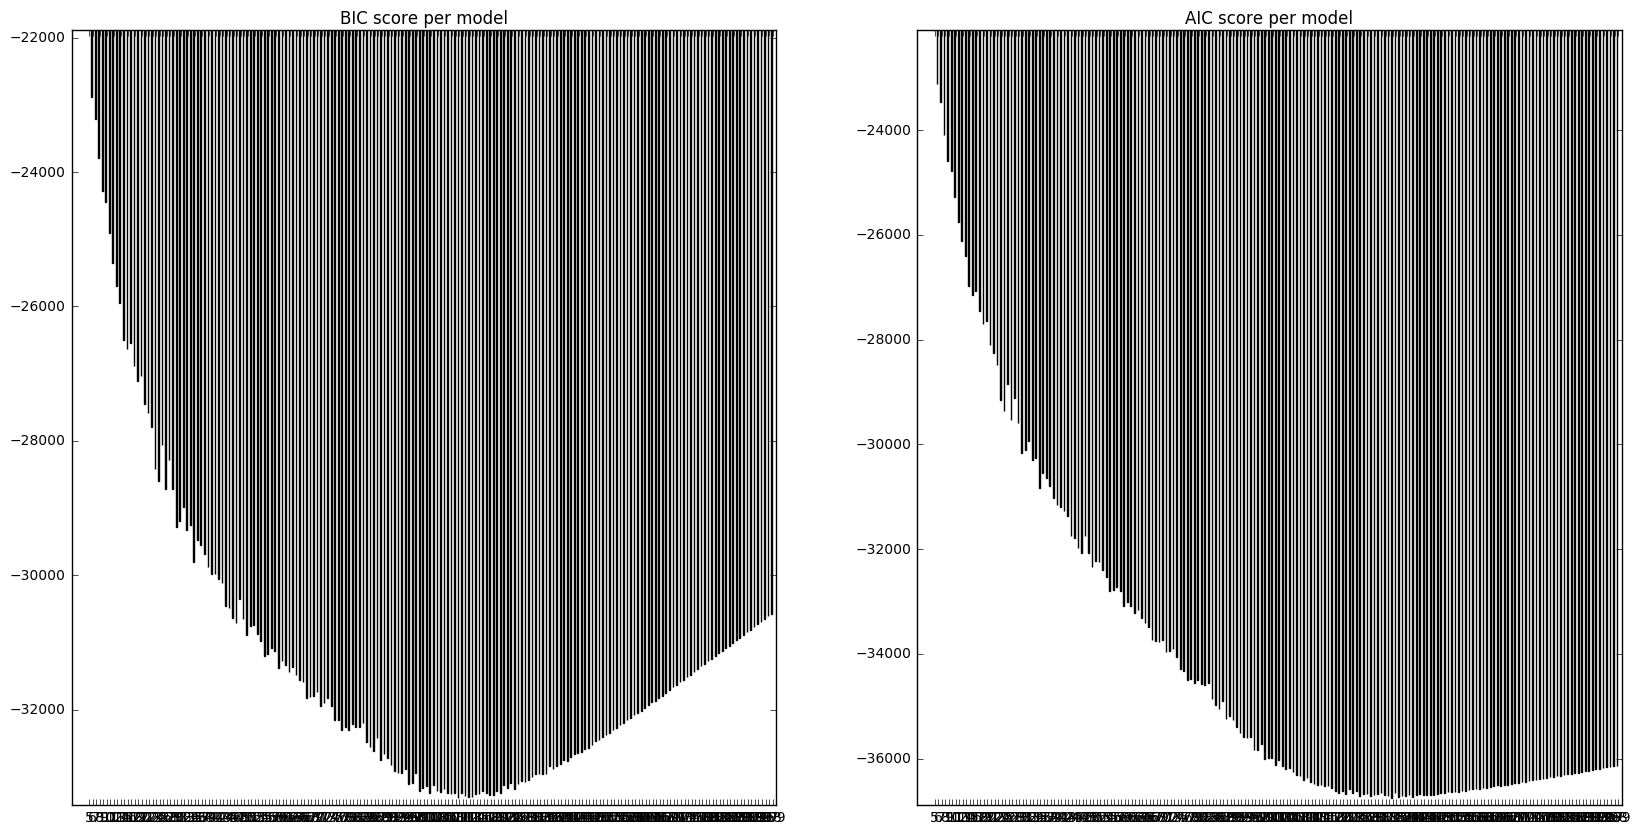

In [14]:
plot_bic_aic(data.loc[2])